In [63]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import zipfile

In [40]:
load_dotenv()

DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')

connection_string = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

In [ ]:
try:
    engine = create_engine(connection_string)
    query = "SELECT * FROM raw.household_appliance_specifications"
    df = pd.read_sql_query(query, engine)
except Exception as e:
    print(f"Error connecting to database or fetching data: {e}")
    df = None

In [ ]:
df = df.drop(columns=['id', 'serial_no', 'unique_id', 'noiw1', 'brand1', 'brand2', 'brand3', 'brand4', 'brand5', 'brand6', 'brand7', 'brand8', 'brand9', 'brand10', 'brand11', 'brand12', 'brand13', 'brand14'])
df = df.set_index('household_id')
df['purchased_time'] = df['purchased_time1'].fillna(df['purchased_time2']).fillna(df['purchased_time3']).fillna(df['purchased_time4'])
df = df.drop(columns=['purchased_time1', 'purchased_time2', 'purchased_time3', 'purchased_time4'])

,appliance_name,no_of_appliances,condition1,condition2,purchased_time
household_id,,,,,
ID0430,Microwave,1.0,None,Second Hand,More than 10 years ago
ID0430,Electric Blender,1.0,Brand New,None,Within the last 1- 5 years
ID0430,Rice cooker,1.0,Brand New,None,Wthin the last 5-10 years
ID0430,Electric Kettle,1.0,None,Second Hand,More than 10 years ago
ID0528,Refrigerator,1.0,Brand New,None,More than 10 years ago


In [ ]:
try:
    engine = create_engine(connection_string)
    query = "select whiah.\"household_ID\", whiah.electricity_provider_csc_area from clean.w1_household_information_and_history whiah"
    df2 = pd.read_sql_query(query, engine)
except Exception as e:
    print(f"Error connecting to database or fetching data: {e}")
    df2 = None

df2 = df2.set_index('household_ID')
df = df.join(df2, how='inner')

np.int64(0)

In [ ]:
age_counts = df.groupby(['electricity_provider_csc_area', 'purchased_time']).size().reset_index(name='count')
age_summary = age_counts.pivot(index='electricity_provider_csc_area', 
                               columns='purchased_time', 
                               values='count').fillna(0)
age_summary['Total'] = age_summary.sum(axis=1)

percentage_cols = []
for col in ['Within the last 1 year', 'Within the last 1- 5 years', 'Wthin the last 5-10 years', 'More than 10 years ago']:
    if col in age_summary.columns:
        age_summary[col] = (age_summary[col] / age_summary['Total'] * 100).round(2)

age_summary = age_summary.rename(columns={
    'Within the last 1 year': '0-1_years',
    'Within the last 1- 5 years': '1-5_years', 
    'Wthin the last 5-10 years': '5-10_years',
    'More than 10 years ago': '10+_years'
})
desired_order = ['0-1_years', '1-5_years', '5-10_years', '10+_years', 'Total']
age_summary = age_summary[desired_order]

purchased_time,0-1_years,1-5_years,5-10_years,10+_years,Total
electricity_provider_csc_area,,,,,
ALUTHGAMA,7.72,74.49,10.08,7.72,972
AMBALANGODA,10.43,60.11,19.40,10.06,1103
BORALASGAMUWA,11.16,66.53,12.34,9.97,1264
DALUGAMA,13.94,59.56,16.83,9.66,1004
GALLE,6.71,72.15,13.92,7.22,1580
HIKKADUWA,9.63,66.39,13.53,10.45,1101
JA-ELA,5.54,71.04,13.12,10.29,884
KALUTARA,10.68,62.52,15.51,11.29,1470
KANDANA,12.57,56.17,19.16,12.10,835


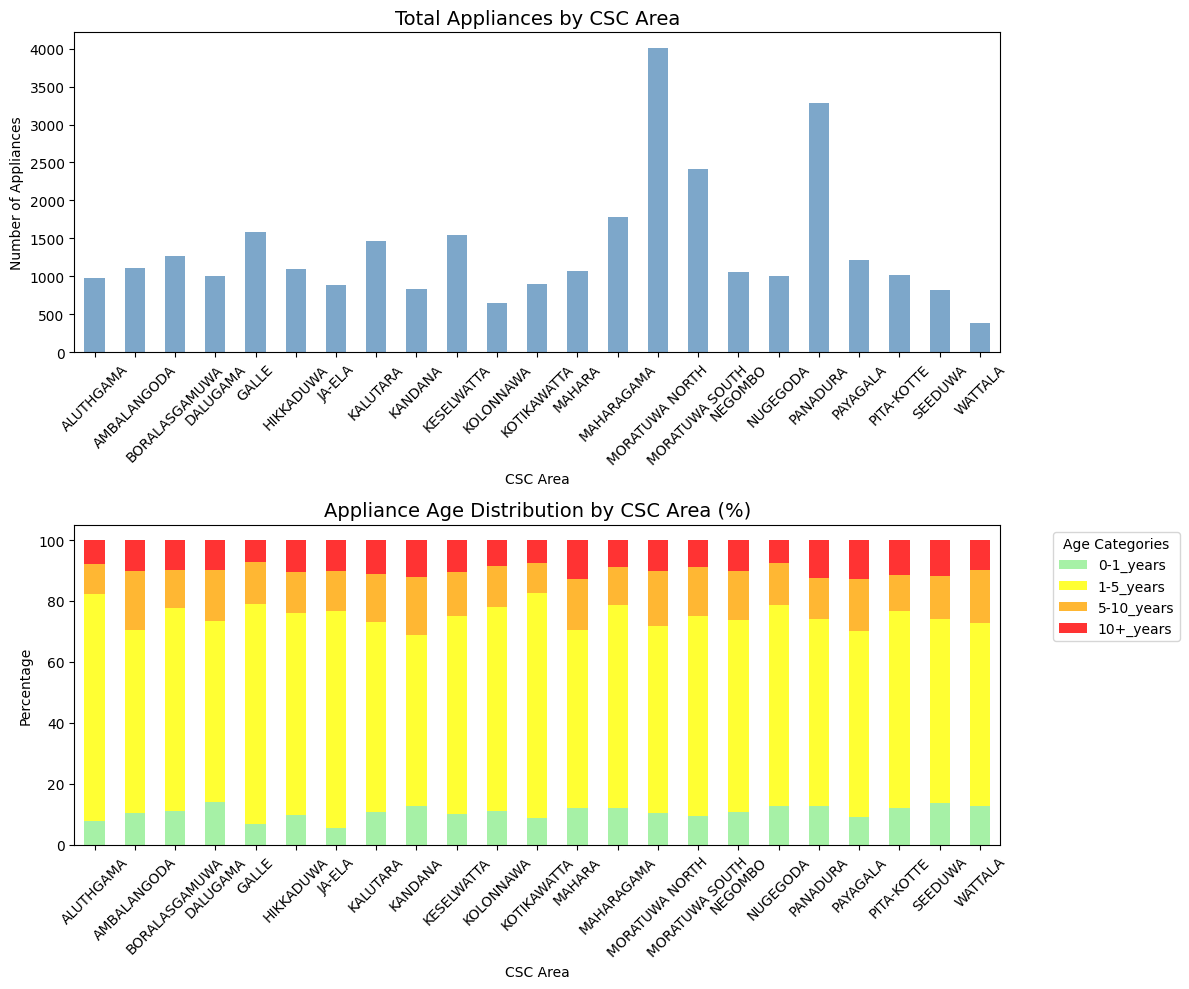

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

age_summary['Total'].plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_title('Total Appliances by CSC Area', fontsize=14)
ax1.set_xlabel('CSC Area')
ax1.set_ylabel('Number of Appliances')
ax1.tick_params(axis='x', rotation=45)

age_data = age_summary[['0-1_years', '1-5_years', '5-10_years', '10+_years']].copy()
age_data.plot(kind='bar', stacked=True, ax=ax2, 
                color=['lightgreen', 'yellow', 'orange', 'red'], alpha=0.8)
ax2.set_title('Appliance Age Distribution by CSC Area (%)', fontsize=14)
ax2.set_xlabel('CSC Area')
ax2.set_ylabel('Percentage')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Age Categories', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()